In [1]:
from petsc4py import PETSc
from mpi4py import MPI
import ufl
from dolfinx import mesh, fem
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
import numpy as np
from petsc4py.PETSc import ScalarType  # type: ignore
t = 0  # Start time
T = 0.5  # End time
num_steps = 50  # Number of time steps
dt = (T - t) / num_steps  # Time step size
R = 3
h = 0.1
nx, ny = int(2*R/h), int(2*R/h)
domain = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((-R, -R), (R, R)), n=(nx, ny),
                            cell_type=mesh.CellType.triangle)
V = fem.FunctionSpace(domain, ("Lagrange", 1))

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)
dofs = fem.locate_dofs_topological(V, entity_dim=1, entities=boundary_facets)
bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)


In [6]:
def gen_coef_gauss9(N_sample, al, au, gl, gu):
    coef = np.zeros((N_sample, 9, 3))
    for n in range(N_sample):
        coef[n,0:9,0] = np.random.rand(9)*(au-al)+al
        coef[n,0:9,1] = np.random.rand(9)*(au-al)+al
        coef[n,0:9,2] = np.random.rand(9)*(gu-gl)+gl
    return coef
N_sample = 1
coef_f = gen_coef_gauss9(N_sample, al=10, au=20, gl=-1.5, gu=1.5)[0]
print(coef_f)

[[11.63203302 13.15827134 -0.36800006]
 [17.04110722 14.02078192  0.0385543 ]
 [18.94976689 11.02759478 -0.11553607]
 [18.52666815 16.86117738  1.26437164]
 [11.87048827 12.09014871 -0.40443845]
 [19.87004871 17.90726645 -0.66013948]
 [13.3558134  16.13947655 -0.45503376]
 [18.82918406 12.59736817 -0.47387598]
 [13.58448576 14.01020714  0.69679423]]


In [13]:
def gen_coef_h_poly3(N_sample,al,au,gl,gu):
    coef = np.zeros((N_sample,2,4))
    for n in range(N_sample):
        coef[n,0:2,0:3] = np.random.rand(2,3)*(au-al)+al
        coef[n,0:2,3:]  = np.random.rand(2,1)*(gu-gl)+gl 
    return coef
N_sample = 1
coef_h = gen_coef_h_poly3(N_sample, al=-1, au=1, gl=0.3, gu=1.)[0]
print(coef_h)

[[-0.69522267 -0.37463649 -0.24612362  0.71926759]
 [ 0.20804272 -0.4421506   0.97767983  0.91895944]]


In [14]:
class initial_condition():
    def __init__(self,coef):
        '''
        coef: 9,3
        '''
        self.coef = coef
        loc = np.zeros((9,2))
        ind = 0
        for ii in range(3):
            for jj in range(3):
                loc[ind,0] = 0.3*ii+0.2-0.5
                loc[ind,1] = 0.3*jj+0.2-0.5
        self.loc = loc       
    def __call__(self, x):
        val = 0
        for i in range(9):
            val += self.coef[i,2]*np.exp(-self.coef[i,0]*(x[0]-self.loc[i,0])**2)*np.exp(-self.coef[i,1]*(x[1]-self.loc[i,1])**2)
        return val
u_init = initial_condition(coef_f)
u_n = fem.Function(V)
u_n.interpolate(u_init)

class ax():
    def __init__(self,coef):
        self.coef = coef #2,4
    def fun(self,x):
        f1 = self.coef[0,0]+self.coef[0,1]*x[0]+self.coef[0,2]*x[0]**2+self.coef[0,3]*x[0]**3
        f2 = self.coef[1,0]+self.coef[1,1]*x[1]+self.coef[1,2]*x[1]**2+self.coef[1,3]*x[1]**3
        return f1,f2
    def __call__(self, x):
        f1,f2 = self.fun(x)
        return np.sin(x[0]) + np.sin(x[1])- 1/2*(f1**2+f2**2)



a_fun = ax(coef_h)
a = fem.Function(V)
a.interpolate(a_fun)

class fx():
    def __init__(self):
        pass
    def __call__(self, x):
        return np.cos(x[0]) ,np.cos(x[1])
f_fun = fx()

v_2 = ufl.VectorElement("Lagrange", domain.ufl_cell(), 2)
V_2 = fem.FunctionSpace(domain, v_2)
f = fem.Function(V_2)
f.interpolate(f_fun)

  value[i,j] = u_n.eval(p[i,j,:], cells[0])



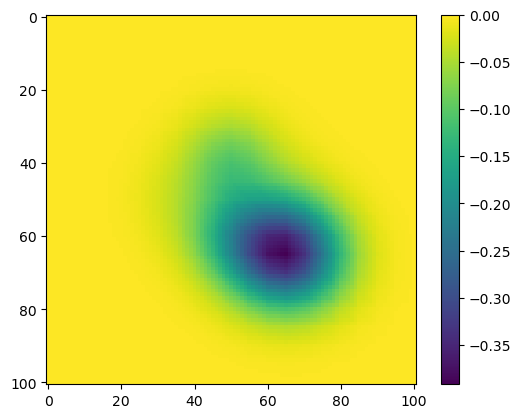

In [15]:
# Create bounding box for function evaluation
import numpy as np
import matplotlib.pyplot as plt
from dolfinx import default_real_type, geometry
bb_tree = geometry.bb_tree(domain, 2)
nx = 100
ny = 100
x = np.linspace(-1,1,nx+1)
y = x
X,Y = np.meshgrid(x,y)
p = np.concatenate((X[:,:,np.newaxis],Y[:,:,np.newaxis],np.zeros((nx+1,ny+1,1))),axis = -1)
# Check against standard table value
#p = np.array([2.,2.,0.], dtype=np.float64)
value = np.zeros((nx+1,ny+1))
u_n.x.scatter_forward()
for i in range(0,nx+1):
    for j in range(0,ny+1):
        cell_candidates = geometry.compute_collisions_points(bb_tree, p[i,j,:])
        cells = geometry.compute_colliding_cells(domain, cell_candidates, p[i,j,:])
        value[i,j] = u_n.eval(p[i,j,:], cells[0])
        
plt.figure()
plt.imshow(value)
plt.colorbar()
plt.show()

  value[i,j] = a.eval(p[i,j,:], cells[0])



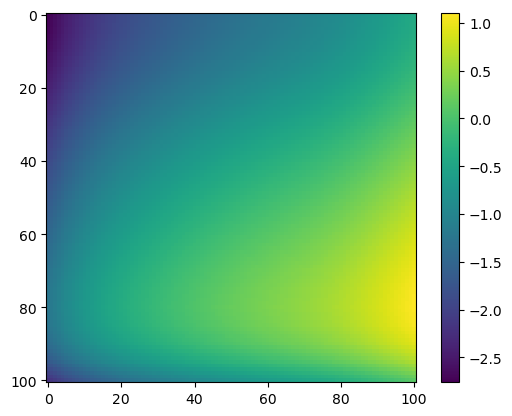

In [16]:
bb_tree = geometry.bb_tree(domain, 2)
nx = 100
ny = 100
x = np.linspace(-1,1,nx+1)
y = x
X,Y = np.meshgrid(x,y)
p = np.concatenate((X[:,:,np.newaxis],Y[:,:,np.newaxis],np.zeros((nx+1,ny+1,1))),axis = -1)
# Check against standard table value
#p = np.array([2.,2.,0.], dtype=np.float64)
value = np.zeros((nx+1,ny+1))
a.x.scatter_forward()
for i in range(0,nx+1):
    for j in range(0,ny+1):
        cell_candidates = geometry.compute_collisions_points(bb_tree, p[i,j,:])
        cells = geometry.compute_colliding_cells(domain, cell_candidates, p[i,j,:])
        value[i,j] = a.eval(p[i,j,:], cells[0])
        
plt.figure()
plt.imshow(value)
plt.colorbar()
plt.show()

In [17]:
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
F = u * v * ufl.dx + 1/2*dt * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx + dt* ufl.dot(f,ufl.grad(u))*v* ufl.dx- dt*a*u*v*ufl.dx - u_n * v * ufl.dx
lhs = fem.form(ufl.lhs(F))
rhs = fem.form(ufl.rhs(F))
A = assemble_matrix(lhs, bcs=[bc])
A.assemble()
b = create_vector(rhs)

In [18]:
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)


In [19]:
uh = fem.Function(V)
for n in range(num_steps):
    # Update Diriclet boundary condition
    # Update the right hand side reusing the initial vector
    with b.localForm() as loc_b:
        loc_b.set(0)
    assemble_vector(b, rhs)

    # Apply Dirichlet boundary condition to the vector
    apply_lifting(b, [lhs], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, uh.vector)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array


  value[i,j] = uh.eval(p[i,j,:], cells[0])



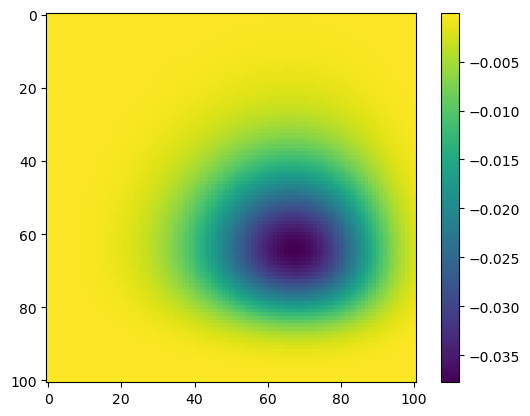

In [20]:
# Create bounding box for function evaluation
import numpy as np
import matplotlib.pyplot as plt
from dolfinx import default_real_type, geometry
bb_tree = geometry.bb_tree(domain, 2)
nx = 100
ny = 100
x = np.linspace(-2,2,nx+1)
y = x
X,Y = np.meshgrid(x,y)
p = np.concatenate((X[:,:,np.newaxis],Y[:,:,np.newaxis],np.zeros((nx+1,ny+1,1))),axis = -1)
# Check against standard table value
#p = np.array([2.,2.,0.], dtype=np.float64)
value = np.ones((nx+1,ny+1))
uh.x.scatter_forward()
for i in range(0,nx+1):
    for j in range(0,ny+1):
        cell_candidates = geometry.compute_collisions_points(bb_tree, p[i,j,:])
        cells = geometry.compute_colliding_cells(domain, cell_candidates, p[i,j,:])
        value[i,j] = uh.eval(p[i,j,:], cells[0])
        
plt.figure()
plt.imshow(value)
plt.colorbar()
plt.show()

In [21]:
from dolfinx import io, plot
with io.XDMFFile(domain.comm, "out_poisson/poisson.xdmf", "w") as file:
    file.write_mesh(domain)
    file.write_function(uh)


No module named 'trame'

Falling back to a static output.
  warnings.warn(



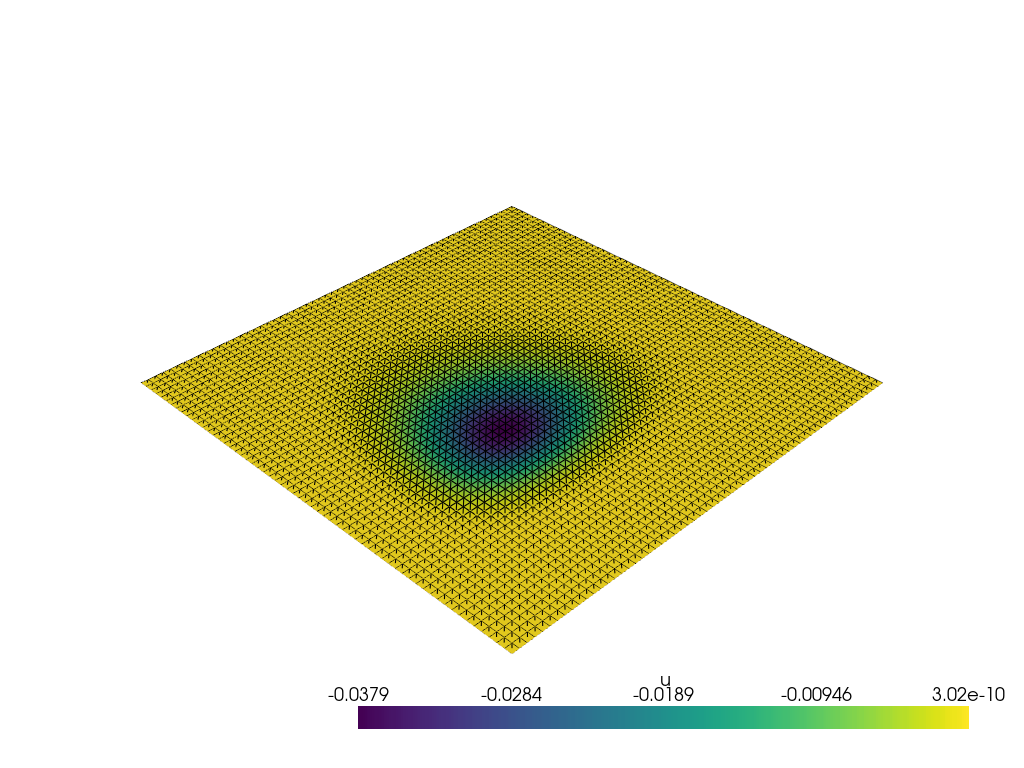

In [22]:
try:
    import pyvista
    cells, types, x = plot.vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    grid.point_data["u"] = uh.x.array.real
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("uh_poisson.png")
    else:
        plotter.show()
except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")


No module named 'trame'

Falling back to a static output.
  warnings.warn(



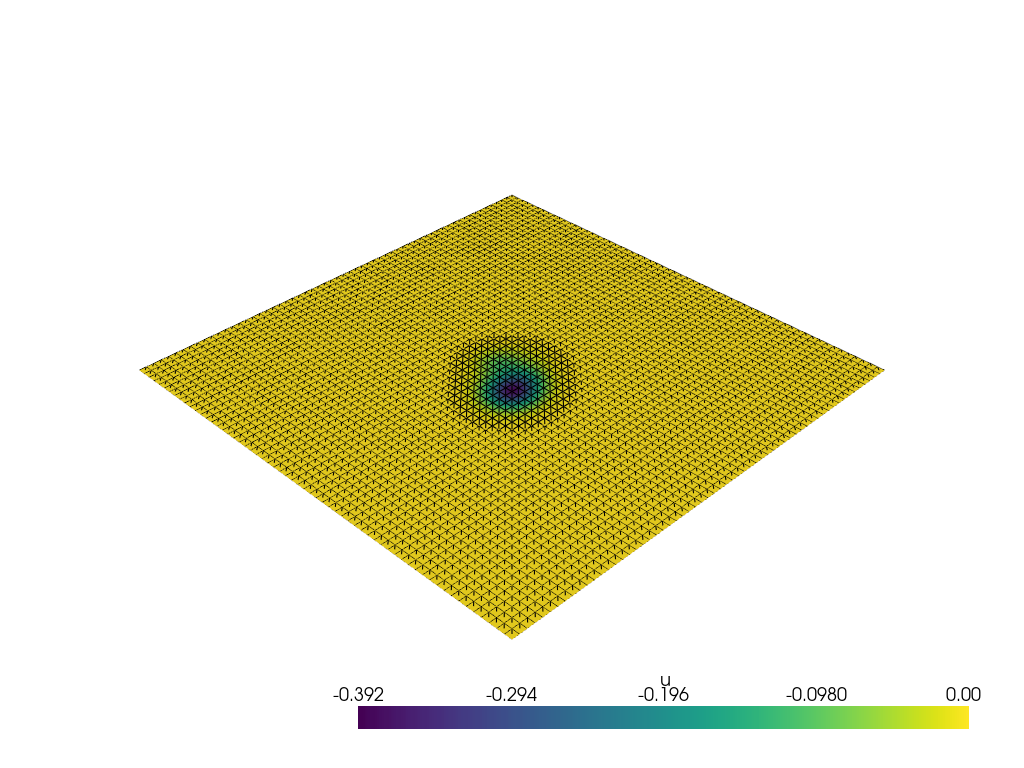

: 

In [23]:
u_n1 = fem.Function(V)
u_n1.interpolate(u_init)
try:
    import pyvista
    cells, types, x = plot.vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    grid.point_data["u"] = u_n1.x.array.real
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("uh_poisson.png")
    else:
        plotter.show()
except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")